**KDE Determined Adaptive Kernel Regression**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

np.random.seed(42)

x = np.sort(np.random.beta(2, 5, 200) * 10)

# True regression function
def f_true(x):
    return np.sin(x)

# Observations with noise
y = f_true(x) + 0.25 * np.random.randn(200)

In [ ]:

def kde_adaptive_kernel_regression(x_train, y_train, x_eval, alpha=0.1):
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_eval = np.asarray(x_eval)

    # KDE on training points
    kde = gaussian_kde(x_train)
    f_hat = kde(x_train)

    # Global bandwidth (Silverman's rule)
    h0 = np.std(x_train) * len(x_train) ** (-1/5)

    # KDE-determined adaptive bandwidths
    h_i = h0 * (f_hat ** (-alpha))

    #Cap extreme bandwidths
    h_min, h_max = np.percentile(h_i, [5, 80])
    h_i = np.clip(h_i, h_min, h_max)

    def gaussian(u):
        return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

    y_pred = np.zeros_like(x_eval)

    for j, x0 in enumerate(x_eval):
        u = (x0 - x_train) / h_i
        weights = gaussian(u) / h_i
        y_pred[j] = np.sum(weights * y_train) / np.sum(weights)

    return y_pred

In [ ]:
x_grid = np.linspace(min(x) - 1, max(x) + 1, 400)

y_kde_adapt = kde_adaptive_kernel_regression(
    x_train=x,
    y_train=y,
    x_eval=x_grid,
    alpha=0.5
)

y_true = f_true(x_grid)

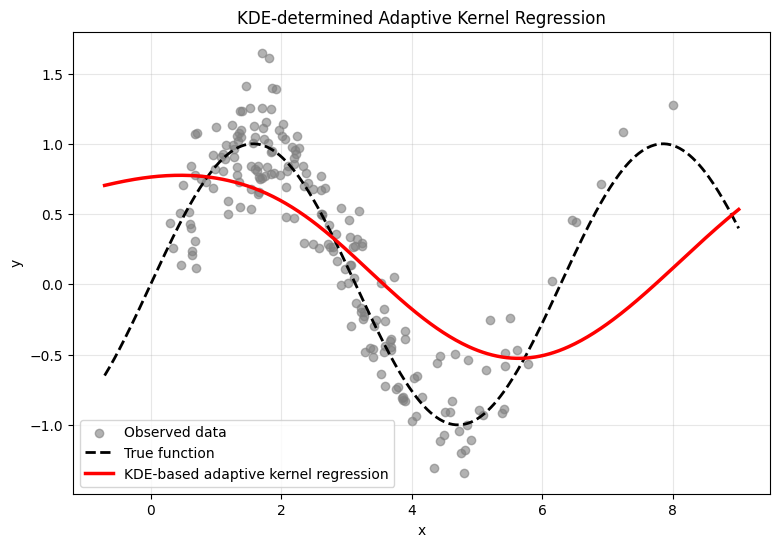

In [ ]:
plt.figure(figsize=(9, 6))

# Data
plt.scatter(x, y, color="gray", alpha=0.6, label="Observed data")

# True function
plt.plot(x_grid, y_true, "k--", linewidth=2, label="True function")

# KDE-based adaptive regression
plt.plot(x_grid, y_kde_adapt, color="red", linewidth=2.5,
         label="KDE-based adaptive kernel regression")

plt.xlabel("x")
plt.ylabel("y")
plt.title("KDE-determined Adaptive Kernel Regression")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

**Using Real World Data**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.datasets import load_diabetes

# Load real dataset
data = load_diabetes()
x = data.data[:, 2]   # BMI (standardized)
y = data.target       # disease progression

# Sort by x (important for plotting)
idx = np.argsort(x)
x = x[idx]
y = y[idx]

In [ ]:

def kde_adaptive_kernel_regression(x_train, y_train, x_eval, alpha=0.3):
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_eval  = np.asarray(x_eval)

    # KDE on predictor
    kde = gaussian_kde(x_train)
    f_hat = kde(x_train)

    # Density floor (stability)
    f_hat = np.maximum(f_hat, np.percentile(f_hat, 5))

    # Global bandwidth
    h0 = np.std(x_train) * len(x_train) ** (-1/5)

    # Adaptive bandwidths
    h_i = h0 * (f_hat ** (-alpha))

    # Clip extreme bandwidths
    h_min, h_max = np.percentile(h_i, [10, 90])
    h_i = np.clip(h_i, h_min, h_max)

    def gaussian(u):
        return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

    y_pred = np.zeros_like(x_eval)

    for j, x0 in enumerate(x_eval):
        u = (x0 - x_train) / h_i
        w = gaussian(u) / h_i
        y_pred[j] = np.sum(w * y_train) / np.sum(w)

    return y_pred

In [ ]:

def bootstrap_ci(x, y, x_grid, B=300, alpha=0.05):
    n = len(x)
    boot_preds = np.zeros((B, len(x_grid)))

    for b in range(B):
        idx = np.random.choice(n, n, replace=True)
        x_b = x[idx]
        y_b = y[idx]

        # Sort bootstrap sample
        order = np.argsort(x_b)
        x_b = x_b[order]
        y_b = y_b[order]

        boot_preds[b] = kde_adaptive_kernel_regression(
            x_b, y_b, x_grid
        )

    lower = np.percentile(boot_preds, 100 * alpha / 2, axis=0)
    upper = np.percentile(boot_preds, 100 * (1 - alpha / 2), axis=0)

    return lower, upper

In [ ]:

x_grid = np.linspace(x.min(), x.max(), 400)

# Point estimate
y_hat = kde_adaptive_kernel_regression(x, y, x_grid)

# Bootstrap confidence intervals
y_lo, y_hi = bootstrap_ci(x, y, x_grid, B=300)

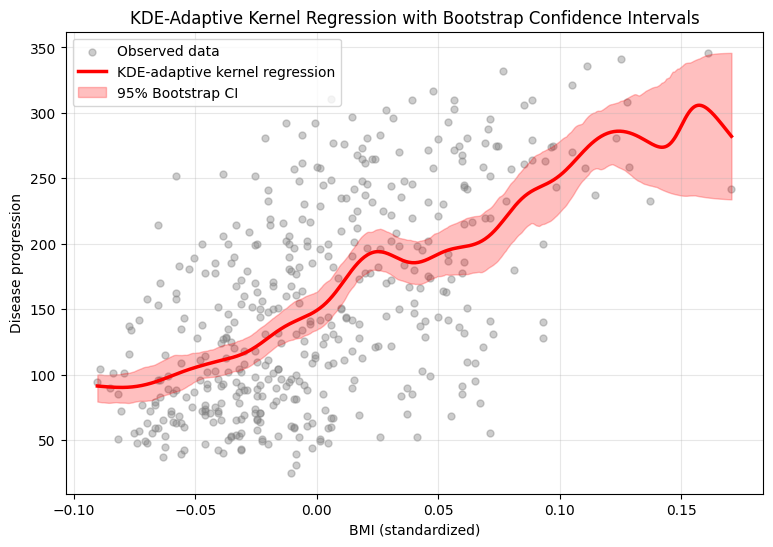

In [ ]:
plt.figure(figsize=(9, 6))

plt.scatter(x, y, s=25, alpha=0.4, color="gray", label="Observed data")

plt.plot(x_grid, y_hat, color="red", lw=2.5,
         label="KDE-adaptive kernel regression")

plt.fill_between(
    x_grid, y_lo, y_hi,
    color="red", alpha=0.25,
    label="95% Bootstrap CI"
)

plt.xlabel("BMI (standardized)")
plt.ylabel("Disease progression")
plt.title("KDE-Adaptive Kernel Regression with Bootstrap Confidence Intervals")
plt.legend()
plt.grid(alpha=0.3)

plt.show()